In [321]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

import funcs.utils as utils
import funcs.plotting as plot
import funcs.amyloid as amyloid
from tqdm import tqdm

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [322]:
PROCESSED_DIR = "data/processed"

### 1. Load Data
---

In [323]:
data_df = pd.read_csv(os.path.join(PROCESSED_DIR, "dataset_processed.tsv"), sep='\t', index_col=0).rename(columns=amyloid.ddict_unclean)

# Fix Dates
data_df = pd.concat([pd.to_datetime(data_df[amyloid.dates][var], format="mixed") for var in amyloid.dates], axis=1, keys=amyloid.dates).join(
    data_df.drop(amyloid.dates, axis=1)  
)

### 2. Load Clustering
---

In [331]:
N_CLUSTERS = 3

In [425]:
ccp_runs = glob.glob("data/clustering/full_dataset/**") + glob.glob("data/clustering/2004_dataset/**") + \
    glob.glob("data/clustering/2008_dataset/**") + ["data/clustering/full_na_dataset"]

result = dict()
clusters_3_df = list()
clusters_4_df = list()

for ccp_file in tqdm(ccp_runs):
    ccp_file_name = ccp_file.split("data/clustering/")[1]
    result[ccp_file_name] = utils.load_ccp_result(ccp_file)
    
    s = utils.get_agg_clust(result[ccp_file_name][N_CLUSTERS-1]['cm'],3)
    s.columns = [ccp_file_name + "_3"]
    clusters_3_df.append(s)

    s = utils.get_agg_clust(result[ccp_file_name][N_CLUSTERS-1]['cm'],4)
    s.columns = [ccp_file_name + "_4"]
    clusters_4_df.append(s)

clusters_3_df = pd.concat(clusters_3_df,axis=1)
clusters_4_df = pd.concat(clusters_4_df,axis=1)

  0%|          | 0/22 [00:00<?, ?it/s]

100%|██████████| 22/22 [01:54<00:00,  5.22s/it]


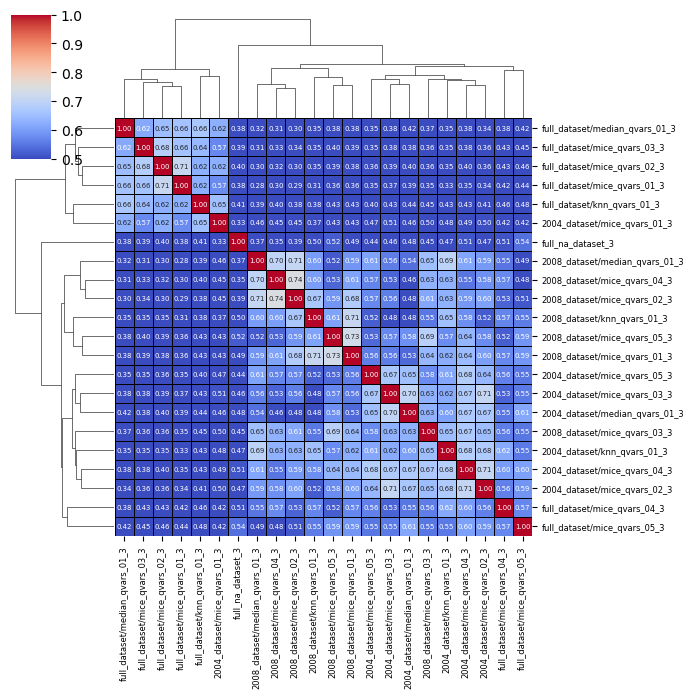

In [426]:
plot.plot_clustermap(utils.compute_ari(clusters_3_df), vmin=0.5, annot=True, fmt=".2f", annot_kws={"size": 5})
plt.savefig("figures/adjusted_rand_index_3_heatmap.pdf", dpi=300, bbox_inches="tight")

In [427]:
def plot_cmatrix(result, run_name="full_na_dataset", k=3, metas=[], **kwargs):
    """_summary_

    Args:
        result (_type_): _description_
        run_name (str, optional): _description_. Defaults to "full_na_dataset".
        k (int, optional): _description_. Defaults to 3.
    """
    from scipy.cluster import hierarchy
    from scipy.spatial import distance

    cm_df = result[run_name][k-1]['cm']

    # Compute linkages
    row_linkage = hierarchy.linkage(distance.pdist(cm_df.values), method='average')
    col_linkage = hierarchy.linkage(distance.pdist(cm_df.values.T), method='average')

    # Create clustermap
    sns.clustermap(
        cm_df,
        row_linkage=row_linkage,
        col_linkage=col_linkage,
        xticklabels=[],
        yticklabels=[],
        rasterized=True,
        figsize=(6,6),
        row_colors=[x[cm_df.index] for x in metas],
        **kwargs
        )

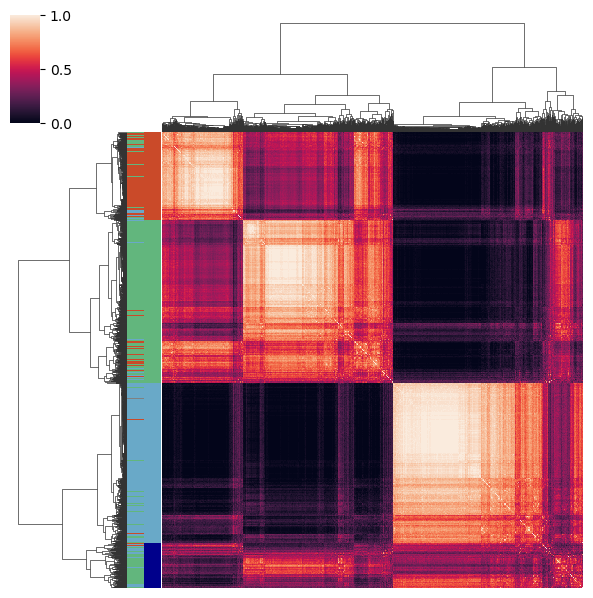

In [474]:
m1 = clusters_3_df['full_na_dataset_3'].fillna("n/a").apply(lambda x: {1:"#69a9c8",2:"#62b67d", 3:"#ca4a29", "n/a":"grey"}[x])
m2 = clusters_4_df['full_dataset/mice_qvars_02_4'].fillna("n/a").apply(lambda x: {1:"darkblue",2:"#62b67d", 3:"#69a9c8", 4:"#ca4a29", "n/a":"grey"}[x])

plot_cmatrix(result, run_name="full_dataset/mice_qvars_02", metas=[m1, m2])
plt.savefig("figures/consensus_heatmap_v2.pdf", dpi=300, bbox_inches='tight')

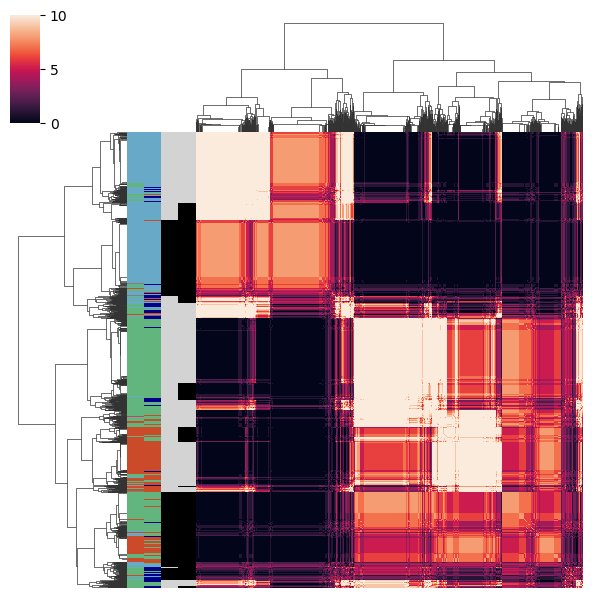

In [478]:
x = np.vstack([clusters_3_df.iloc[:,x].values for x in range(clusters_3_df.shape[1])])
consensus_matrix = np.vstack([(x[:,[y]] == x[:]).sum(0) for y in range(x.shape[1])])

# Get columns for number of datasets in
s2004 = clusters_3_df['2004_dataset/mice_qvars_04_3'].fillna(0).apply(lambda x: "black" if x==0 else "lightgrey")
s2008 = clusters_3_df['2008_dataset/mice_qvars_04_3'].fillna(0).apply(lambda x: "black" if x==0 else "lightgrey")

plot.plot_clustermap(
    consensus_matrix, 
    linewidths=0, 
    xticklabels=False, 
    yticklabels=False, 
    vmin=0, 
    vmax=10, 
    row_colors=[m1, m2, s2004, s2008], 
    cmap=None,
    figsize=(6,6),
    rasterized=True
    )

plt.savefig("figures/meta_consensus_heatmap_v2.pdf", dpi=300, bbox_inches='tight')

In [500]:
meta_df = clusters_3_df[['full_na_dataset_3','full_dataset/mice_qvars_02_3']].join(clusters_4_df['full_dataset/mice_qvars_02_4'])
meta_df = meta_df.rename(columns={'full_na_dataset_3':'fna3_cluster', 'full_dataset/mice_qvars_02_3':'m02q3_cluster','full_dataset/mice_qvars_02_4':'m02q4_cluster'})

meta_df["fna3_cluster_n"] = meta_df["fna3_cluster"].fillna('n/a').apply(lambda x: {1:'Low', 2:'Intermediate', 3:'High','n/a':'n/a'}[x])
meta_df["m02q3_cluster_n"] = meta_df["m02q3_cluster"].fillna('n/a').apply(lambda x: {1:'Intermediate', 2:'High', 3:'Low','n/a':'n/a'}[x])
meta_df["m02q4_cluster_n"] = meta_df["m02q4_cluster"].fillna('n/a').apply(lambda x: {1:'High', 2:'Intermediate_a', 3:'Low',4:'Intermediate_b','n/a':'n/a'}[x])

In [502]:
meta_df.groupby(["fna3_cluster_n","m02q3_cluster_n"]).size()

fna3_cluster_n  m02q3_cluster_n
High            High                12
                Intermediate       377
                Low                  7
Intermediate    High               137
                Intermediate       710
                Low                 67
Low             High                52
                Intermediate        52
                Low                653
n/a             High                 2
                Intermediate         2
                Low                  3
dtype: int64

In [504]:
data_df.join(meta_df).rename(columns=amyloid.ddict_clean).to_csv(os.path.join(PROCESSED_DIR,"AL_with_ccp_03.tsv"), sep="\t")

### 3. Run Enrichments
---

In [399]:
Xi_mice = pd.read_csv("data/imputed/full_dataset/mice_qvars_02.tsv", sep="\t", index_col=0).rename(
    columns={'X24_hr_UTP':'24_hr_UTP'}).rename(columns=amyloid.ddict_unclean)

In [59]:
# Comparison for Numeric
qvars = np.array(Xi_mice.columns)

# Run rank-sum tests
contrasts_df = utils.get_contrasts(data_df, "cluster", qvars)
contrasts_df.to_csv("data/clustering/mice_qvars_05/contrasts_qvars.tsv", sep="\t")

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 14.06it/s]


In [60]:
# Fisher Exact for Categoricals
from sksurv.preprocessing import OneHotEncoder

# Comparison for Categoricals
# Drop due to high missingness
to_drop = ["Age","Amyloid type","Secondary organ","Arrhythmia ","(Autonomic)",
           "(Peripheral)","SIFE M-component","UIFE M-component",
           "Education", "Abdominal fat pad CR staining", "Bone marrow CR staining"]

catvars = list(set(amyloid.catvars)-set(to_drop))

# If uncertain or equivocal, do not include in fisher exact
_cat_df = data_df[catvars].replace({
    "uncertain":np.nan,
    "equivocal":np.nan,
    "involved":"yes",
    "not_involved":"no"})

_cat_df["Race"] = _cat_df["Race"].apply(lambda x: "Other" if x in ['Multiracial','Native_Hawaiian_Pacific', 'Unknown/other'] else x)
_cat_df = _cat_df.astype("category")

# Collapse Race
_cat_df = OneHotEncoder().fit_transform(_cat_df)

contrasts_fe_df = utils.fisher_exact(_cat_df, data_df["cluster"])
contrasts_fe_df['feat'] = contrasts_fe_df['feat'].str.replace("=yes","")
contrasts_fe_df.to_csv("data/clustering/mice_qvars_05/contrasts_fe.tsv", sep="\t")

### 4. Pincipal Components Analysis
---

Can perform this either:
* With imputed data
* With probabalistic PCA (`ppca`), in exploration

In [400]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

alpha=0.7
xlim=(None,7.5)
ylim=(None,7)

In [401]:
# Using MICE imputed
P_df, pca, pca_vars = utils.get_pcs(Xi_mice)

In [402]:
np.cumsum(pca.explained_variance_ratio_)

array([0.11293563, 0.21697636, 0.29424424, 0.35908807, 0.41616392])

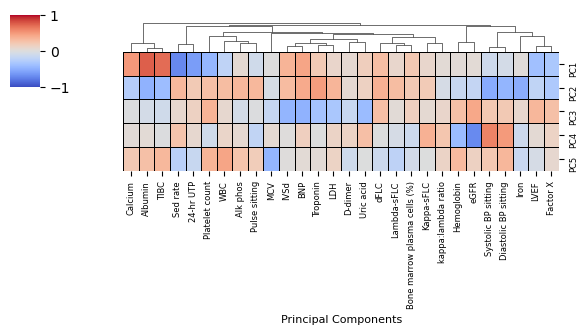

In [403]:
# Correlation between variables and PCs
plot.plot_clustermap(
    P_df.join(Xi_mice).corr('spearman').loc[Xi_mice.columns, P_df.columns].rename(columns={0:"PC1",1:"PC2",2:"PC3",3:"PC4",4:"PC5"}).T,
    figsize=(6,4),
    xlabel='Principal Components',
    col_cluster=True, row_cluster=False
)

#plt.savefig("figures/mice_imputed_pca_corr.pdf", dpi=200, bbox_inches="tight")

In [414]:
meta_df

,cluster,cluster4,cluster_i,cluster4_i,cluster_c,cluster4_c,full_dataset/mice_qvars_02_3,full_na_dataset_3,full_dataset/mice_qvars_02_4
6102,Low,Low,3,3,#62b67d,#62b67d,1,3.0,2
9338,Intermediate,Intermediate,1,2,#69a9c8,#69a9c8,2,2.0,1
9419,Intermediate,Intermediate,1,2,#69a9c8,#69a9c8,3,2.0,3
9421,High,High,2,1,#ca4a29,#ca4a29,1,3.0,4
9422,High,High,2,1,#ca4a29,#ca4a29,1,3.0,4
...,...,...,...,...,...,...,...,...,...
2023166,Intermediate,Low-Intermediate,1,4,#69a9c8,#B6C9BA,3,1.0,3
2023177,Low,Low,3,3,#62b67d,#62b67d,1,3.0,2
2023181,Low,Low,3,3,#62b67d,#62b67d,1,3.0,2
2023191,High,High,2,1,#ca4a29,#ca4a29,1,3.0,2


<Axes: xlabel='PC 2 (10.40%)', ylabel='PC 1 (11.29%)'>

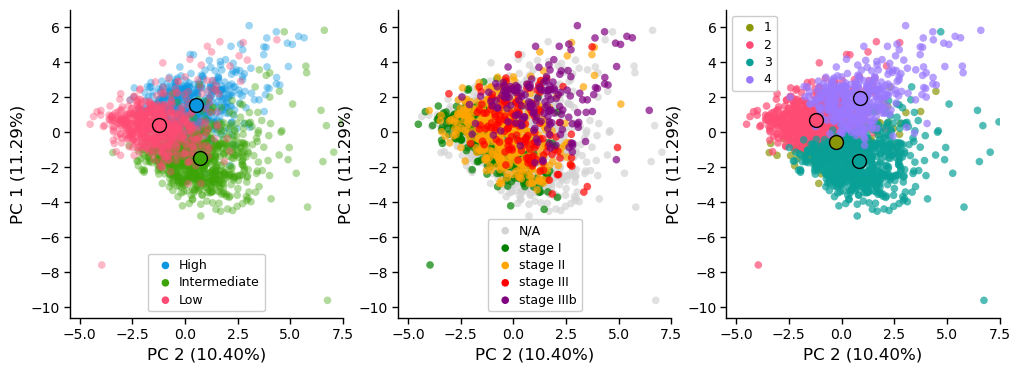

In [418]:
fig,axes = plt.subplots(1,3,figsize=(12,4), sharex=True, sharey=True)

plot.plot_pca_ax(P_df, pca, cohort_s=meta_df.loc[P_df.index, "cluster"], 
                 ax=axes[0], 
                 #cohort_colors=cluster_colors,
                 xlim=xlim, ylim=ylim,
                 alpha=0.4,
                 add_mean_marker=True
                 )

plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index, "BU (BNP-based) cardiac staging"].fillna("N/A"), 
                 ax=axes[1], 
                 cohort_colors={"stage I":"green","stage II":"orange","stage III":"red","stage IIIb":"purple","N/A":"lightgrey"},
                 xlim=xlim, ylim=ylim,
                 alpha=alpha
                 )

plot.plot_pca_ax(P_df, pca, cohort_s=meta_df.loc[P_df.index, "full_dataset/mice_qvars_02_4"],
                 ax=axes[2], 
                 #cohort_colors={"stage I":"green","stage II":"orange","stage III":"red","stage IIIb":"purple","N/A":"lightgrey"},
                 xlim=xlim, ylim=ylim,
                 alpha=alpha,
                 add_mean_marker=True
                 )

<Axes: xlabel='PC 2 (10.40%)', ylabel='PC 1 (11.29%)'>

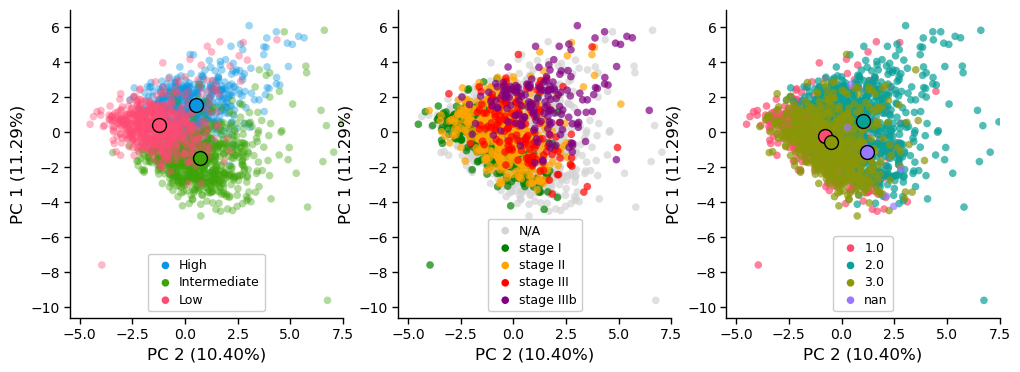

In [406]:
fig,axes = plt.subplots(1,3,figsize=(12,4), sharex=True, sharey=True)

plot.plot_pca_ax(P_df, pca, cohort_s=meta_df.loc[P_df.index, "cluster"], 
                 ax=axes[0], 
                 #cohort_colors=cluster_colors,
                 xlim=xlim, ylim=ylim,
                 alpha=0.4,
                 add_mean_marker=True
                 )

plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index, "BU (BNP-based) cardiac staging"].fillna("N/A"), 
                 ax=axes[1], 
                 cohort_colors={"stage I":"green","stage II":"orange","stage III":"red","stage IIIb":"purple","N/A":"lightgrey"},
                 xlim=xlim, ylim=ylim,
                 alpha=alpha
                 )

plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index,:].join(meta_full_df)['agg_clust_3'].astype(str).fillna("N/A"), 
                 ax=axes[2], 
                 #cohort_colors={"stage I":"green","stage II":"orange","stage III":"red","stage IIIb":"purple","N/A":"lightgrey"},
                 xlim=xlim, ylim=ylim,
                 alpha=alpha,
                 add_mean_marker=True
                 )

In [31]:
# Order cluster subtypes
from pandas.api.types import CategoricalDtype

data_df["cluster"] = data_df["cluster"].astype(CategoricalDtype(categories=["Low","Intermediate","High"], ordered=True))

In [15]:
fig,axes = plt.subplots(1,2,figsize=(8,4), sharex=True, sharey=True)

plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index, "cluster"], 
                 ax=axes[0], 
                 cohort_colors=cluster_colors,
                 xlim=xlim, ylim=ylim,
                 alpha=0.4,
                 add_mean_marker=True
                 )

plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index, "BU (BNP-based) cardiac staging"].fillna("N/A"), 
                 ax=axes[1], 
                 cohort_colors={"stage I":"green","stage II":"orange","stage III":"red","stage IIIb":"purple","N/A":"lightgrey"},
                 xlim=xlim, ylim=ylim,
                 alpha=alpha
                 )

axes[0].set_title("Cluster", fontsize=14)
axes[1].set_title("BU 2019 Staging", fontsize=14)
plt.savefig("figures/mice_pca_clusters_vs_staging.pdf", dpi=200, bbox_inches="tight")

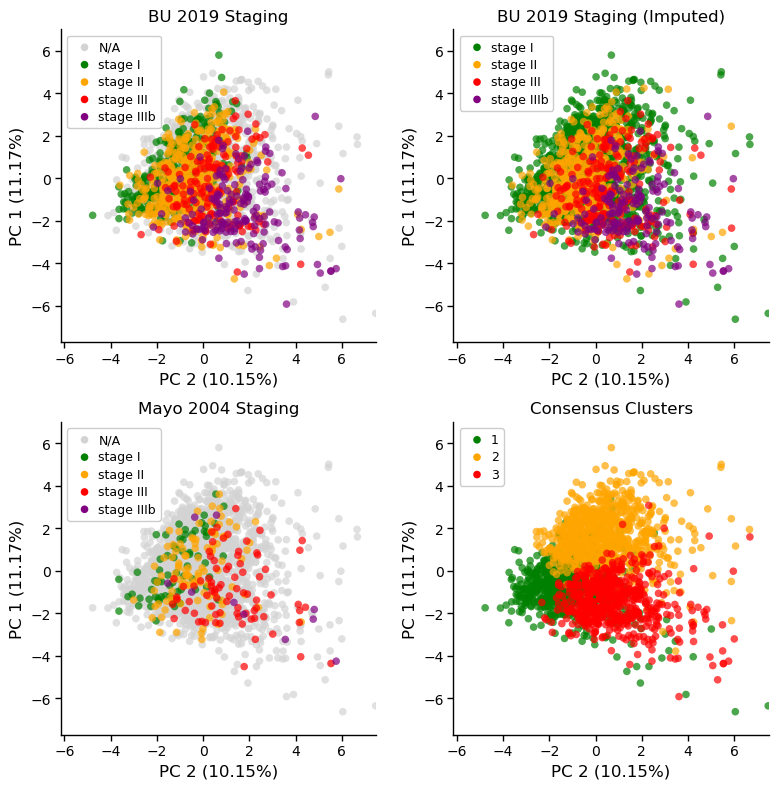

In [14]:
fig,axes = plt.subplots(2,2,figsize=(8,8), sharex=True, sharey=True)

plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index, "BU (BNP-based) cardiac staging"].fillna("N/A"), 
                 ax=axes[0,0], 
                 cohort_colors={"stage I":"green","stage II":"orange","stage III":"red","stage IIIb":"purple","N/A":"lightgrey"},
                 xlim=xlim, ylim=ylim,
                 alpha=alpha
                 )

plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index,:].apply(lambda row: utils.assign_bu_stage(row), 1), 
                 ax=axes[0,1], 
                 cohort_colors={"stage I":"green","stage II":"orange","stage III":"red","stage IIIb":"purple","N/A":"lightgrey"},
                 xlim=xlim, ylim=ylim,
                 alpha=alpha
                 )

plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index, "Mayo  2004 cardiac biomarker staging"].fillna("N/A"), 
                 ax=axes[1,0], 
                 cohort_colors={"stage I":"green","stage II":"orange","stage III":"red","stage IIIb":"purple","N/A":"lightgrey"},
                 xlim=xlim, ylim=ylim,
                 alpha=alpha
                 )

plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index,"cluster"].astype(int), 
                 ax=axes[1,1], 
                 cohort_colors={1:"green",2:"orange",3:"red"},
                 xlim=xlim, ylim=ylim, alpha=alpha
                 )

axes[0,0].set_title("BU 2019 Staging")
axes[0,1].set_title("BU 2019 Staging (Imputed)")
axes[1,0].set_title("Mayo 2004 Staging")
axes[1,1].set_title("Consensus Clusters")
plt.tight_layout()

plt.savefig("figures/mice_pca_staging.pdf", dpi=200, bbox_inches="tight")

/var/folders/m0/69jv0yz94wd23rxxdwwkcn9w0000gp/T/ipykernel_56211/1562964913.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


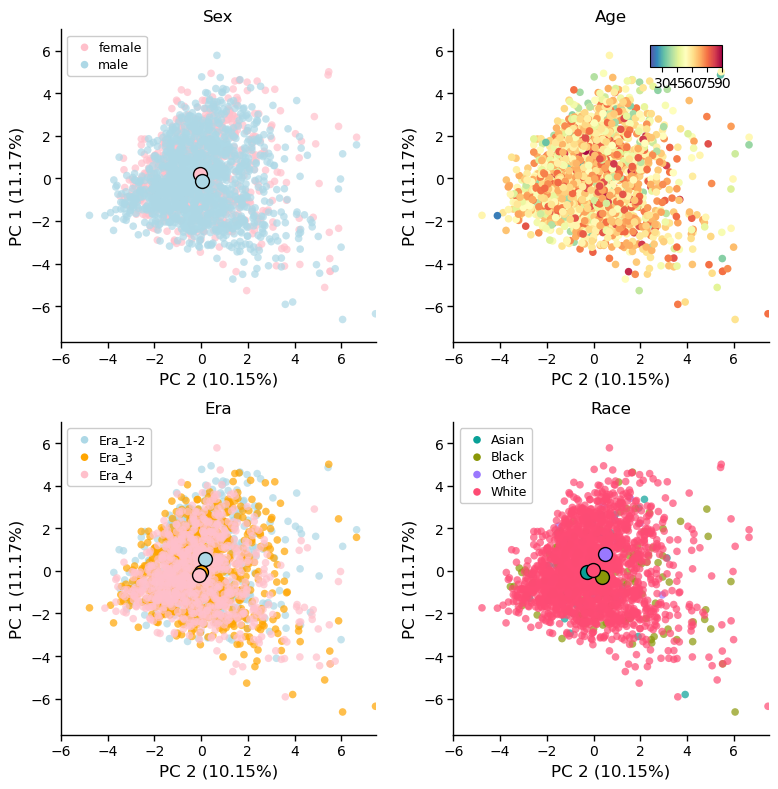

In [49]:
fig,axes = plt.subplots(2,2,figsize=(8,8), sharex=True, sharey=True)

alpha=0.7
xlim=(None,7.5)
ylim=(None,7)

plot.plot_pca_ax(P_df, pca, c=data_df.loc[P_df.index, "Age"], ax=axes[0,1], xlim=xlim, ylim=ylim)
plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index, "Sex"], ax=axes[0,0], 
                 xlim=xlim, ylim=ylim, cohort_colors={"female":"pink","male":"lightblue"}, alpha=alpha, add_mean_marker=True)
plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index, "Era"], ax=axes[1,0], 
                 xlim=xlim, ylim=ylim, cohort_colors={"Era_1-2":"lightblue","Era_3":"orange","Era_4":"pink"}, alpha=alpha, add_mean_marker=True)
plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index, "Race"].apply(
                lambda x: "Other" if x in ['American_Indian_Alaska_Native','Multiracial','Native_Hawaiian_Pacific', 'Unknown/other'] else x),
                 ax=axes[1,1], xlim=xlim, ylim=ylim, alpha=alpha, add_mean_marker=True)

axes[0,0].set_title("Sex")
axes[0,1].set_title("Age")
axes[1,0].set_title("Era")
axes[1,1].set_title("Race")

plt.tight_layout()
plt.savefig("figures/mice_pca_demo.pdf", dpi=200, bbox_inches="tight")


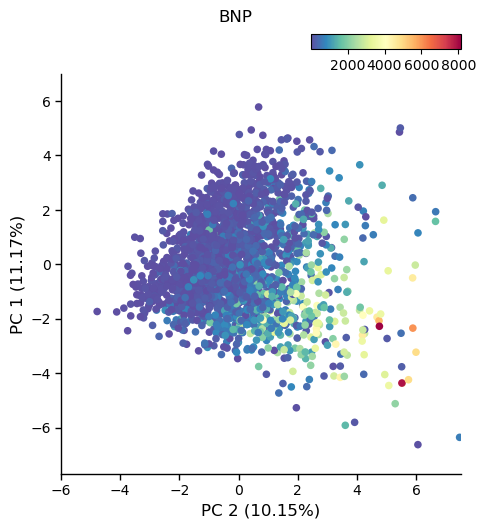

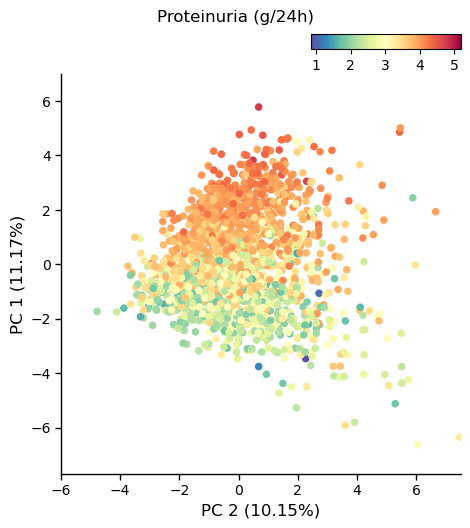

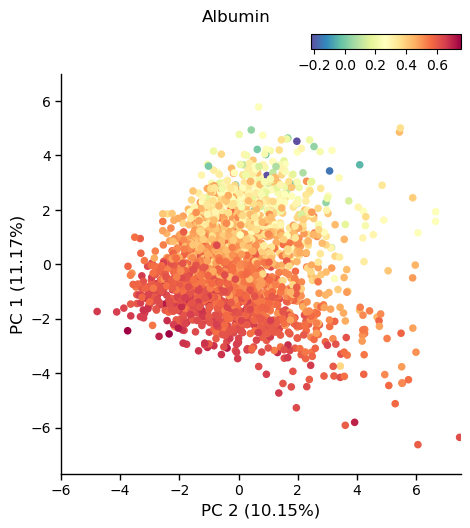

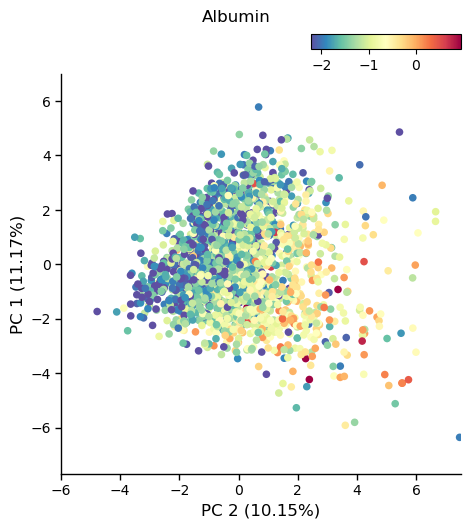

In [52]:
_ = plot.plot_pca(
    P_df,
    pca,
    c=Xi_mice.loc[P_df.index, "BNP"],
    show_ax2=False,
    xlim=xlim,
    ylim=ylim, title="BNP"
)

_ = plot.plot_pca(
    P_df,
    pca,
    c=np.log10(Xi_mice.loc[P_df.index, "24-hr UTP"]),
    show_ax2=False,
    xlim=xlim,
    ylim=ylim, title = "Proteinuria (g/24h)"
)

_ = plot.plot_pca(
    P_df,
    pca,
    c=np.log10(Xi_mice.loc[P_df.index, "Albumin"]),
    show_ax2=False,
    xlim=xlim,
    ylim=ylim, title = "Albumin"
)

_ = plot.plot_pca(
    P_df,
    pca,
    c=np.log10(Xi_mice.loc[P_df.index, "Troponin"]),
    show_ax2=False,
    xlim=xlim,
    ylim=ylim, title = "Albumin"
)

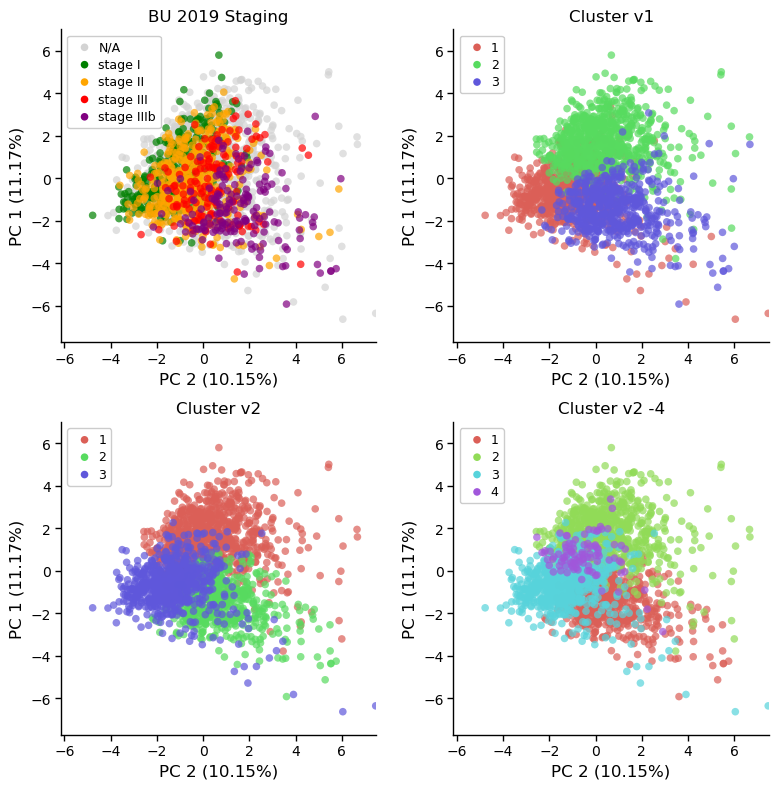

In [87]:
fig,axes = plt.subplots(2,2,figsize=(8,8), sharex=True, sharey=True)

plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index, "BU (BNP-based) cardiac staging"].fillna("N/A"), 
                 ax=axes[0,0], 
                 cohort_colors={"stage I":"green","stage II":"orange","stage III":"red","stage IIIb":"purple","N/A":"lightgrey"},
                 xlim=xlim, ylim=ylim,
                 alpha=alpha
                 )

plot.plot_pca_ax(P_df, pca, cohort_s=meta_df.loc[P_df.index,"cluster"], 
                 ax=axes[0,1], 
                 cohort_colors=cluster_colors,
                 xlim=xlim, ylim=ylim,
                 alpha=alpha
                 )

plot.plot_pca_ax(P_df, pca, cohort_s=meta_df.loc[P_df.index,"agg_clust_3"], 
                 ax=axes[1,0], 
                 cohort_colors=cluster_colors,
                 xlim=xlim, ylim=ylim,
                 alpha=alpha
                 )

plot.plot_pca_ax(P_df, pca, cohort_s=meta_df.loc[P_df.index,"agg_clust_4"], 
                 ax=axes[1,1], 
                 cohort_colors=cluster_colors_4,
                 xlim=xlim, ylim=ylim,
                 alpha=alpha
                 )

axes[0,0].set_title("BU 2019 Staging")
axes[0,1].set_title("Cluster v1")
axes[1,0].set_title("Cluster v2")
axes[1,1].set_title("Cluster v2 -4")
plt.tight_layout()

### 5. Probablistic PCA
---
* In exploration

In [123]:
def get_ppca(X_df: pd.DataFrame, normalize:bool=True):
    """Get Probablistic PCA

    Args:
        X (pd.DataFrame): _description_
        normalize (bool, optional): _description_. Defaults to True.

    Returns:
        _type_: _description_
    """
    from ppca import PPCA
    import scipy
    from sklearn.preprocessing import StandardScaler

    if normalize:
        X = StandardScaler().fit_transform(X_df.values)
    else:
        X = X_df.values
    
    ppca = PPCA()
    ppca.fit(X, d=100, verbose=False)

    P_df = pd.DataFrame(ppca.data, index=X_df.index, columns=range(ppca.data.shape[1]))
    ppca.explained_variance_ratio_ = ppca.var_exp

    return P_df, ppca

ppca_df, ppca = get_ppca(data_df.loc[Xi_mice.index,Xi_mice.columns])